In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import time

Reading and observing the dataset at hand

In [2]:
ls

README.md         house prices.csv  reduction.ipynb   sonar.all-data


In [3]:
df = pd.read_csv('house prices.csv')
df.drop('Id', inplace=True, axis=1)

In [4]:
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [6]:
def show_nans():
    nan_df = pd.DataFrame(df.isna().sum(axis=0), columns=['nan-count'])
    nan_df = nan_df.sort_values('nan-count', ascending=False)
    return nan_df

Removing Nan values if possible and replacing them with the Nan values defined specifically for each

In [7]:
df['PoolQC'].fillna('NA', inplace=True)
df['MiscFeature'].fillna('NA', inplace=True)
df['Alley'].fillna('NA', inplace=True)
df['Fence'].fillna('NA', inplace=True)
df['FireplaceQu'].fillna('NA', inplace=True)
df['GarageCond'].fillna('NA', inplace=True)
df['GarageFinish'].fillna('NA', inplace=True)
df['GarageQual'].fillna('NA', inplace=True)
df['GarageType'].fillna('NA', inplace=True)
df['BsmtFinType2'].fillna('NA', inplace=True)
df['BsmtFinType1'].fillna('NA', inplace=True)
df['BsmtExposure'].fillna('NA', inplace=True)
df['BsmtCond'].fillna('NA', inplace=True)
df['BsmtQual'].fillna('NA', inplace=True)
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace=True) # should be experimented
show_nans()

,nan-count
GarageYrBlt,81
MasVnrType,8
MasVnrArea,8
Electrical,1
KitchenQual,0
...,...
ExterCond,0
ExterQual,0
Exterior2nd,0
Exterior1st,0


In [8]:
df.drop('GarageYrBlt', axis=1, inplace=True)

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(1451, 79)

In [11]:
number_df = df.select_dtypes('number')
object_df = df.select_dtypes('object')

In [12]:
number_df.shape, object_df.shape

((1451, 36), (1451, 43))

In [13]:
object_df.head(3)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NA,NA,NA,WD,Normal


In [14]:
number_df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


In [15]:
for column in object_df.columns:
    object_df[column] = pd.factorize(object_df[column])[0]

<ipython-input-15-57231cb53607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  object_df[column] = pd.factorize(object_df[column])[0]


In [16]:
df = pd.concat([number_df, object_df], axis=1)

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

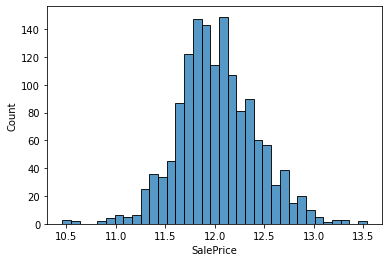

In [17]:
sns.histplot(np.log(df['SalePrice']))

In [18]:
def scaler_features(df, log_target, target_column):
    df_copy = df.copy()
    df_copy_target = df_copy.pop(target_column)
    if log_target:
        df_copy_target = np.log1p(df_copy_target)
    df_copy_target.reset_index(drop=True, inplace=True)
    scaler = MinMaxScaler()
    df_copy = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)
    df_copy = pd.concat([df_copy, df_copy_target], axis=1)
    return df_copy

### First Part

<AxesSubplot:>

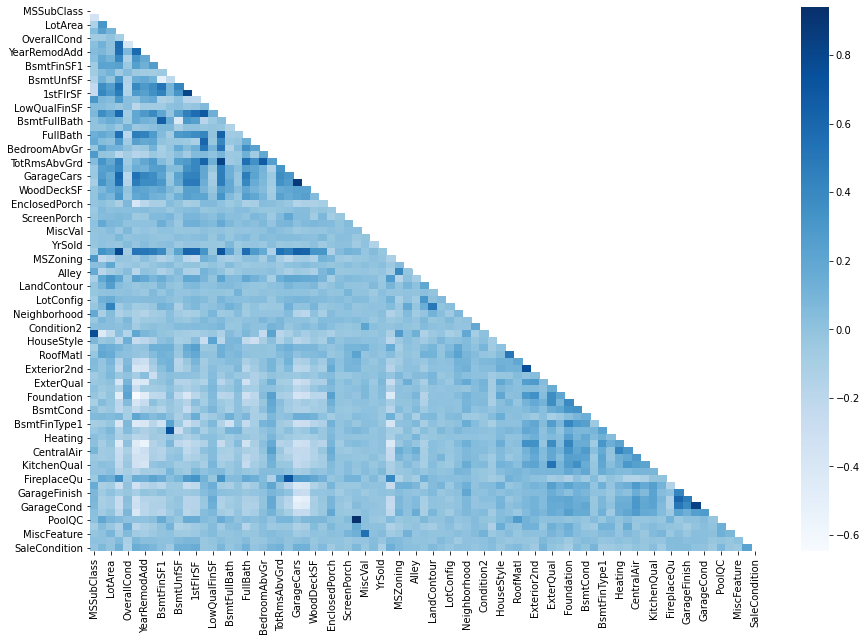

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), mask=np.triu(df.corr()), cmap='Blues')

In [20]:
d = scaler_features(df, True, 'SalePrice')

In [21]:
y_df = d.pop('SalePrice')
X_df = d

In [22]:
X_df

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0.235294,0.150685,0.033420,0.666667,0.500,0.949275,0.883333,0.122500,0.125089,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.753623,0.433333,0.000000,0.173281,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.934783,0.866667,0.101250,0.086109,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.311594,0.333333,0.000000,0.038271,0.000000,...,0.166667,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.2
4,0.235294,0.215753,0.060576,0.777778,0.500,0.927536,0.833333,0.218750,0.116052,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,0.235294,0.140411,0.030929,0.555556,0.500,0.920290,0.833333,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1447,0.000000,0.219178,0.055505,0.555556,0.625,0.768116,0.633333,0.074375,0.139972,0.110583,...,0.000000,0.333333,0.0,0.0,0.0,0.0,0.25,0.00,0.0,0.0
1448,0.294118,0.154110,0.036187,0.666667,1.000,0.500000,0.933333,0.000000,0.048724,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.75,0.25,0.0,0.0
1449,0.000000,0.160959,0.039342,0.444444,0.625,0.565217,0.766667,0.000000,0.008682,0.698100,...,0.000000,0.333333,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0


In [23]:
y_df

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1446    12.072547
1447    12.254868
1448    12.493133
1449    11.864469
1450    11.901590
Name: SalePrice, Length: 1451, dtype: float64

Linear regression model

In [24]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_df, y_df)

LinearRegression()

In [25]:
intercept = regressor.intercept_
features = pd.DataFrame(regressor.coef_, X_df.columns, columns=['coefficient'])
features.sort_values('coefficient', ascending=False).head()

,coefficient
BsmtFinSF1,4.548913e+12
1stFlrSF,3.475287e+12
BsmtUnfSF,1.882753e+12
2ndFlrSF,1.646734e+12
BsmtFinSF2,1.188005e+12


In [26]:
features.coefficient = features.coefficient.abs()
stdevs = []
for i in X_df.columns:
    stdev = d[i].std()
    stdevs.append(stdev)

features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]

In [27]:
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()

In [28]:
features = features.sort_values('importance_normalized', ascending=False).head(10)

<BarContainer object of 10 artists>

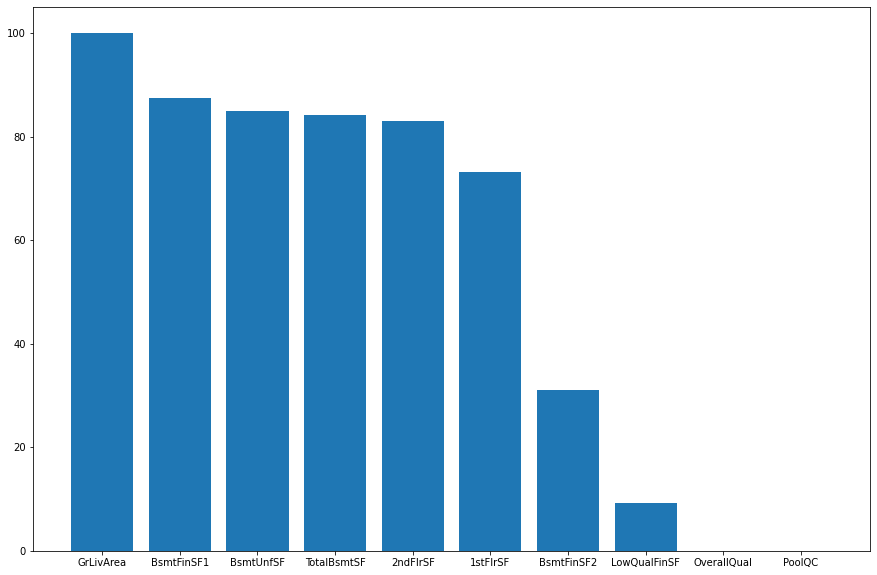

In [29]:
plt.figure(figsize=(15, 10))
plt.bar(features.index, features.importance_normalized)

Decision Tree model

In [30]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_df, y_df)

DecisionTreeRegressor(max_depth=5)

In [31]:
feature_importance = pd.Series(dtr.tree_.compute_feature_importances(), index=X_df.columns)

In [32]:
feature_importance = feature_importance.sort_values(ascending=False).head(10)

<BarContainer object of 10 artists>

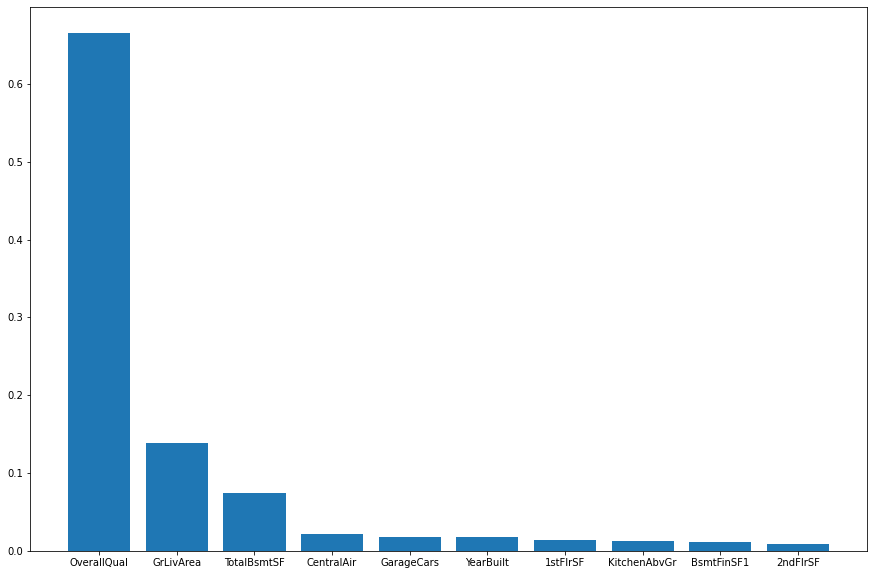

In [33]:
plt.figure(figsize=(15, 10))
plt.bar(feature_importance.index, feature_importance.values)

---

### Backward Elimination

In [34]:
bias = pd.Series(np.ones(X_df.shape[0]), name='bias')
X_df = pd.concat([X_df, bias], axis=1)

In [35]:
import statsmodels.api as sm

In [36]:
start_time = time.time()
X_dff = X_df.copy()
p_value_threshold = 0.05
non_usefull_feature = []
while True: 
    model = sm.OLS(y_df, X_dff)
    results = model.fit()
    highest_p_value = -np.inf
    worst_feature = None
    for i in range(len(results.pvalues)):
        if results.pvalues[i] > p_value_threshold and results.pvalues[i] > highest_p_value:
            worst_feature = results.pvalues.index[i]
            highest_p_value = results.pvalues[i]
    if not worst_feature:
        print(results.pvalues)
        break
    print('removing {} feature'.format(worst_feature))
    non_usefull_feature.append(worst_feature)
    X_dff.drop(worst_feature, axis=1, inplace=True)
end_time = time.time()
print('Time took for the operation of backward elimination: {}s'.format(np.round(end_time - start_time, 3)))

removing Exterior2nd feature
removing Heating feature
removing GarageCond feature
removing LowQualFinSF feature
removing MoSold feature
removing GarageFinish feature
removing BsmtUnfSF feature
removing MSSubClass feature
removing BedroomAbvGr feature
removing 2ndFlrSF feature
removing GarageQual feature
removing BsmtFinType1 feature
removing Electrical feature
removing MasVnrArea feature
removing HouseStyle feature
removing LotShape feature
removing MasVnrType feature
removing BsmtHalfBath feature
removing Exterior1st feature
removing BsmtExposure feature
removing Alley feature
removing MSZoning feature
removing BsmtFinType2 feature
removing BsmtFinSF2 feature
removing GarageArea feature
removing LotFrontage feature
removing BsmtCond feature
removing BsmtQual feature
removing MiscVal feature
removing MiscFeature feature
removing OpenPorchSF feature
removing EnclosedPorch feature
removing Utilities feature
removing ExterQual feature
removing 3SsnPorch feature
removing SaleCondition feat

### Model

In [37]:
def to_dataloader(df, target_col, batch_size):
    target = torch.tensor(df[target_col].values.astype(np.float32))
    data = torch.tensor(df.drop(target_col, axis=1).values.astype(np.float32))

    data_tensor = torch.utils.data.TensorDataset(data, target)
    data_loader = DataLoader(data_tensor, shuffle=True, batch_size=batch_size)
    return data_loader

Definition of the model

In [38]:
class Regressor_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Regressor_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        for i in range(n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(n_layers):
            x = self.activation_function(self.fcs[i](x))
        x = self.fcs[-1](x)
        x = x.squeeze(1)
        return x

In [39]:
def train(model, train_loader, test_loader, criterion_mse, criterion_mae, optimizer):
    start_time = time.time()
    epochs_loss_mse = []
    epochs_loss_mae = []
    epochs_loss_mse_test = []
    epochs_loss_mae_test = []
    for epoch in tqdm(range(n_epochs), leave=False):
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(train_loader):
            outputs = model(data)
            mse = criterion_mse(outputs, targets)
            optimizer.zero_grad()
            mse.backward()
            optimizer.step()
            
            with torch.no_grad():
                mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())
            batchs_loss_mae.append(mae.item())
        
        epochs_loss_mse.append(np.mean(batchs_loss_mse))
        epochs_loss_mae.append(np.mean(batchs_loss_mae))
        batchs_loss_mse_test, batchs_loss_mae_test, _, _ = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
        epochs_loss_mse_test.append(batchs_loss_mse_test)
        epochs_loss_mae_test.append(batchs_loss_mae_test)
    end_time = time.time()
    print('Time took for the operation of training: {}s'.format(np.round(end_time - start_time, 3)))
    return epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test

In [40]:
def check_accuracy(model, loader, criterion_mse, criterion_mae):
    model.eval()
    outputs_agg = np.array([])
    targets_agg = np.array([])
    with torch.no_grad():
        batchs_loss_mse = []
        batchs_loss_mae = []
        for batch_idx, (data, targets) in enumerate(loader):
            outputs = model(data)
            outputs_agg = np.append(outputs_agg, outputs.numpy())
            targets_agg = np.append(targets_agg, targets.numpy())
            mse = criterion_mse(outputs, targets)
            mae = criterion_mae(outputs, targets)
            batchs_loss_mse.append(mse.item())     
            batchs_loss_mae.append(mae.item())
    print('mse error :{}, mae error :{}'.format(np.mean(batchs_loss_mse), np.mean(batchs_loss_mae)))
    model.train()
    return np.mean(batchs_loss_mse), np.mean(batchs_loss_mae), outputs_agg, targets_agg

In [41]:
def plot_losses(epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_loss_mse, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_loss_mse_test, label='test data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('MSE loss per epoch')
    sns.lineplot(data=epochs_loss_mae, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_mae_test, label='test data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('MAE loss per epoch')
    plt.tight_layout()

In [42]:
def plot_predictions(outputs_agg, targets_agg):
    fig = plt.figure(figsize=(10, 10))
    sns.scatterplot(y=outputs_agg, x=targets_agg)
    plt.ylabel('predictions')
    plt.xlabel('targets')
    plt.ylim((np.min(targets_agg), np.max(targets_agg)))

In [43]:
batch_size = 64
dff = scaler_features(df, True, 'SalePrice')
train_df = dff.sample(frac=.8, random_state=707)
test_df = dff.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)

In [44]:
input_size = dff.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

mse error :139.06755676269532, mae error :11.786794853210449
mse error :58.499020385742185, mae error :7.6226122856140135
mse error :4.222745704650879, mae error :1.5598093032836915
mse error :2.3389929294586183, mae error :1.2519361615180968
mse error :2.3477595806121827, mae error :1.270323061943054
mse error :1.8879043817520142, mae error :1.1257742643356323
mse error :1.6447672843933105, mae error :1.0587538719177245
mse error :1.540491485595703, mae error :1.023443841934204
mse error :1.3152980089187623, mae error :0.9449540138244629
mse error :1.2087713956832886, mae error :0.9103488326072693
mse error :1.0185843229293823, mae error :0.8318707108497619
mse error :0.8937090158462524, mae error :0.7755385518074036
mse error :0.7978343367576599, mae error :0.7302939295768738
mse error :0.7666895270347596, mae error :0.716814398765564
mse error :0.6875577688217163, mae error :0.6808778285980225
mse error :0.6329132318496704, mae error :0.6502381205558777
mse error :0.5997854948043824

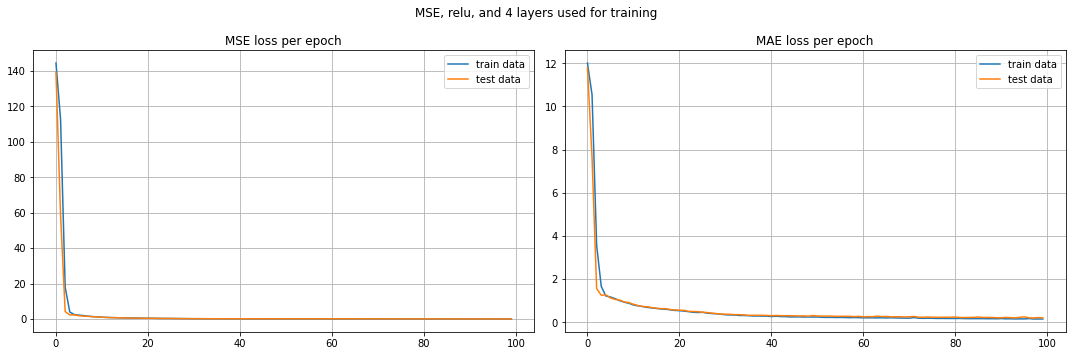

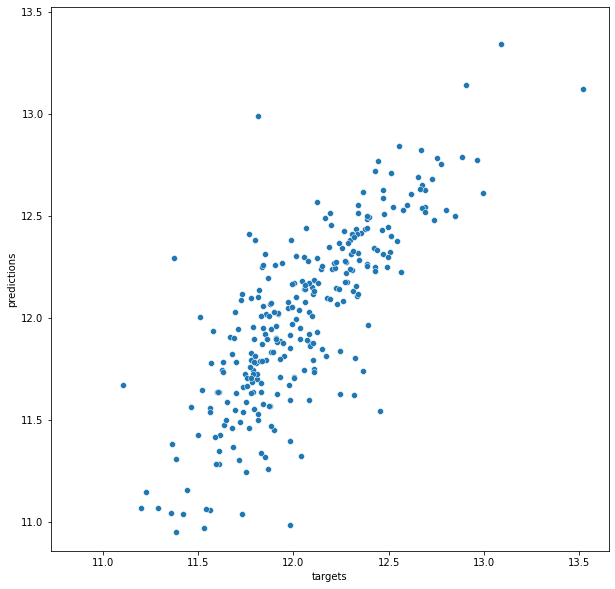

In [45]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)
_, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
plot_predictions(outputs_agg, targets_agg)

In [46]:
batch_size = 64
dff = df.drop(non_usefull_feature, axis=1)
dff = scaler_features(dff, True, 'SalePrice')
train_df = dff.sample(frac=.8, random_state=707)
test_df = dff.drop(train_df.index)

train_loader = to_dataloader(
    df=train_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)
test_loader = to_dataloader(
    df=test_df, 
    target_col='SalePrice', 
    batch_size=batch_size
)

In [47]:
input_size = dff.shape[1] - 1
n_layers = 4
hidden_size = [100, 64, 32, 16]
activation_function = F.relu
output_size = 1
lr = 0.001
n_epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

mse error :140.65885009765626, mae error :11.853993988037109
mse error :106.58332672119141, mae error :10.319725608825683
mse error :3.8007092475891113, mae error :1.6508813619613647
mse error :3.50745530128479, mae error :1.5776976108551026
mse error :2.6501372337341307, mae error :1.3152235984802245
mse error :2.2754595041275025, mae error :1.2420226335525513
mse error :2.1024450063705444, mae error :1.1931097507476807
mse error :1.8449382305145263, mae error :1.1154902935028077
mse error :1.6505516052246094, mae error :1.0489814639091493
mse error :1.4055741548538208, mae error :0.9572110176086426
mse error :1.2923675775527954, mae error :0.9215348243713379
mse error :1.2076369524002075, mae error :0.894520354270935
mse error :1.0686586141586303, mae error :0.8357381105422974
mse error :0.914668869972229, mae error :0.7679911017417907
mse error :0.821113109588623, mae error :0.7296551942825318
mse error :0.7365530014038086, mae error :0.6961706042289734
mse error :0.6824448347091675

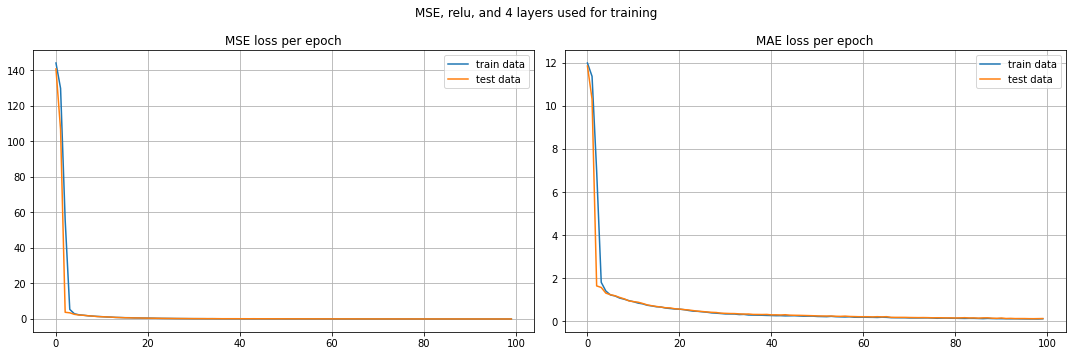

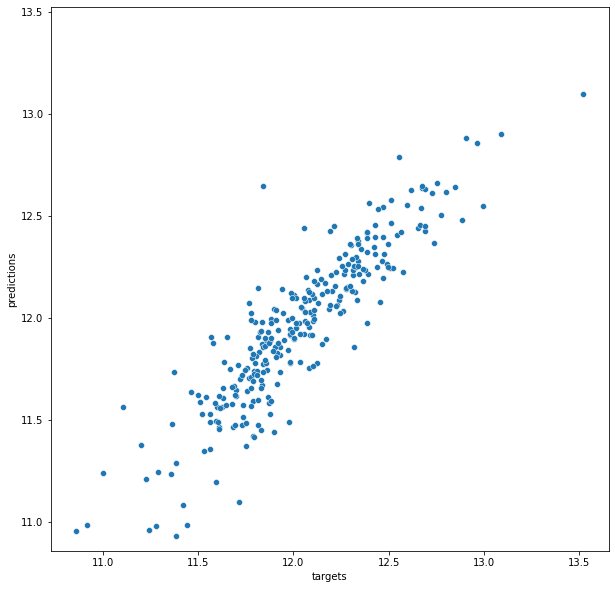

In [48]:
model = Regressor_nn(
    input_size=input_size, 
    hidden_size=hidden_size, 
    n_layers=n_layers, 
    output_size=output_size, 
    activation_function=activation_function
)

criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr)
epochs_loss_mse, epochs_loss_mae, epochs_loss_mse_test, epochs_loss_mae_test = train(
    model, 
    train_loader,
    test_loader,
    criterion_mse,
    criterion_mae,
    optimizer
)
plot_losses(
    epochs_loss_mse, 
    epochs_loss_mae,
    epochs_loss_mse_test,
    epochs_loss_mae_test,
    'MSE, {}, and {} layers used for training'.format(str(activation_function).split()[1], str(len(hidden_size)))
)
_, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion_mse, criterion_mae)
plot_predictions(outputs_agg, targets_agg)

### PCA dimensionality reduction

In [112]:
def plot_losses(epochs_acc, epochs_loss, epochs_acc_test, epochs_loss_test, title):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(title)
    sns.lineplot(data=epochs_acc, label='train data', ax=axs[0])
    sns.lineplot(data=epochs_acc_test, label='val data', ax=axs[0])
    axs[0].grid()
    axs[0].set_title('Acc per epoch')
    sns.lineplot(data=epochs_loss, label='train data', ax=axs[1])
    sns.lineplot(data=epochs_loss_test, label='val data', ax=axs[1])
    axs[1].grid()
    axs[1].set_title('Loss per epoch')
    plt.tight_layout()

In [113]:
from sklearn.metrics import confusion_matrix, classification_report

In [114]:
sonar_df = pd.read_csv('sonar.all-data', header=None)

In [115]:
from imblearn.over_sampling import SMOTE
def resamplingDataPrep(X_train, y_train, target_var): 
    # concatenate our training data back together
    resampling = X_train.copy()
    resampling[target_var] = y_train.values
    # separate minority and majority classes
    majority_class = resampling[resampling[target_var]==0]
    minority_class = resampling[resampling[target_var]==1]
    # Get a class count to understand the class imbalance.
    print('majority_class: '+ str(len(majority_class)))
    print('minority_class: '+ str(len(minority_class)))
    return majority_class, minority_class


def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    print(len(X_train_sm), len(y_train_sm))
    return X_train_sm, y_train_sm

In [116]:
from sklearn.decomposition import PCA

start_time = time.time()

sonar_y_df = sonar_df.pop(60)
sonar_y_df = pd.Series(pd.factorize(sonar_y_df)[0], name=60)
sonar_X_df = sonar_df

sonar_X_df, sonar_y_df = upsample_SMOTE(sonar_X_df, sonar_y_df)

pca = PCA(n_components=50)
sonar_X_df = pd.DataFrame(pca.fit_transform(sonar_X_df))

end_time = time.time()
print('Time took for the operation of training: {}s'.format(np.round(end_time - start_time, 3)))

222 222
Time took for the operation of training: 0.024s


In [117]:
sonar_df = pd.concat([sonar_X_df, sonar_y_df], axis=1)

In [118]:
class Classifier_nn(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Classifier_nn, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.bcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        self.bcs.append(nn.BatchNorm1d(hidden_size[0]))
        for i in range(self.n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            self.bcs.append(nn.BatchNorm1d(hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.bcs[i](self.activation_function(self.fcs[i](x)))
        x = self.fcs[self.n_layers](x)
        x = x.squeeze(1)
        return x

In [119]:
def train(model, train_loader, val_loader, criterion, optimizer, n_epochs):
    best_val_acc = -np.inf
    epochs_acc = []
    epochs_loss = []
    epochs_acc_val = []
    epochs_loss_val = []
    for epoch in tqdm(range(n_epochs), leave=False):
        epoch_acc = []
        epoch_loss = []
        for data, targets in train_loader:
            targets = targets.type(torch.LongTensor)
            outputs = model(data)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
#                 preds = torch.round(torch.sigmoid(outputs))
                _, preds = outputs.max(1)
                acc = (preds == targets).sum() / len(targets)
            epoch_acc.append(acc.item())
            epoch_loss.append(loss.item())
        
        epochs_acc.append(np.mean(epoch_acc))
        epochs_loss.append(np.mean(epoch_loss))
        epoch_acc_val, epoch_loss_val, _, _ = check_accuracy(model, val_loader, criterion, False)
        epochs_acc_val.append(epoch_acc_val)
        epochs_loss_val.append(epoch_loss_val)
        if epoch_acc_val > best_val_acc:
            best_val_acc = epoch_acc_val
            torch.save(model.state_dict(), 'model.pt')
    return epochs_acc, epochs_loss, epochs_acc_val, epochs_loss_val

In [120]:
def check_accuracy(model, loader, criterion, log):
    model.eval()
    targets_agg = np.array([])
    outputs_agg = np.array([])
    with torch.no_grad():
        epoch_acc = []
        epoch_loss = []
        for data, targets in loader:
            targets = targets.type(torch.LongTensor)
            targets_agg = np.append(targets_agg, targets.numpy())
            outputs = model(data)
            loss = criterion(outputs, targets)
#             preds = torch.round(torch.sigmoid(outputs))
            _, preds = outputs.max(1)
            outputs_agg = np.append(outputs_agg, preds.numpy())
            acc = (preds == targets).sum()/len(targets)
            epoch_acc.append(acc.item())     
            epoch_loss.append(loss.item())
    if log:
        print('accuracy: {}, loss: {}'.format(np.mean(epoch_acc), np.mean(epoch_loss)))
    model.train()
    return np.mean(epoch_acc), np.mean(epoch_loss), outputs_agg, targets_agg

In [121]:
from sklearn.model_selection import train_test_split
def test_model(model_name, df, input_size, n_layers, hidden_size, activation_function, output_size, lr, n_epochs, batch_size):
    df = df.copy()
    y = df.pop(60)
    X = df
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, shuffle=True, test_size=.2)
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    train_loader = to_dataloader(
        df=train_df, 
        target_col=60, 
        batch_size=batch_size
    )
    test_loader = to_dataloader(
        df=test_df, 
        target_col=60, 
        batch_size=batch_size
    )
    val_loader = to_dataloader(
        df=val_df, 
        target_col=60, 
        batch_size=batch_size
    )
    model = model_name(
        input_size=input_size, 
        hidden_size=hidden_size, 
        n_layers=n_layers, 
        output_size=output_size, 
        activation_function=activation_function
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)
    epochs_acc, epochs_loss, epochs_acc_val, epochs_loss_val = train(
        model, 
        train_loader,
        val_loader,
        criterion,
        optimizer, 
        n_epochs
    )
    plot_losses(
        epochs_acc,
        epochs_loss,
        epochs_acc_val,
        epochs_loss_val,
        'Loss, and {} layers used for training'.format(str(len(hidden_size)))
    )
    model = model_name(
        input_size=input_size, 
        hidden_size=hidden_size, 
        n_layers=n_layers, 
        output_size=output_size, 
        activation_function=activation_function
    )
    model.load_state_dict(torch.load('model.pt'))
    _, _, outputs_agg, targets_agg = check_accuracy(model, test_loader, criterion, True)
    fig = plt.figure()
    sns.heatmap(confusion_matrix(y_true=targets_agg, y_pred=outputs_agg), annot=True)
    print(classification_report(y_pred=outputs_agg, y_true=targets_agg))

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.9333333373069763, loss: 0.23839403688907623
              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94        23
         1.0       0.95      0.91      0.93        22

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45

time took for the network to be trained :1.743


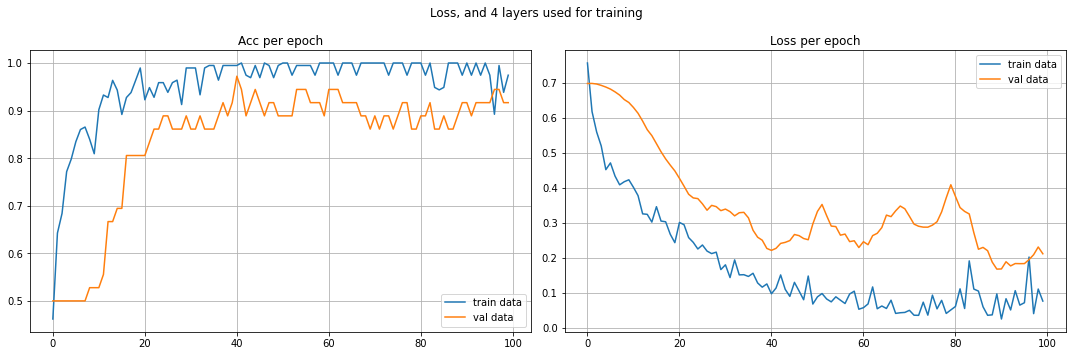

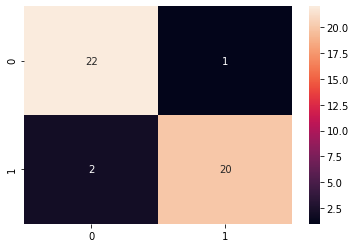

In [126]:
start_time = time.time()
test_model(Classifier_nn, sonar_df, sonar_df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 2, 0.001, 100, 64)
end_time = time.time()
print('time took for the network to be trained :{}'.format(np.round(end_time - start_time, 3)))

### Best Model

In [127]:
sonar_df = pd.read_csv('sonar.all-data', header=None)

In [128]:
sonar_y_df = sonar_df.pop(60)
sonar_y_df = pd.Series(pd.factorize(sonar_y_df)[0], name=60)
sonar_X_df = sonar_df

sonar_X_df, sonar_y_df = upsample_SMOTE(sonar_X_df, sonar_y_df)
sonar_df = pd.concat([sonar_X_df, sonar_y_df], axis=1)

222 222


  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.8666666746139526, loss: 0.33089715242385864
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87        22
         1.0       0.90      0.83      0.86        23

    accuracy                           0.87        45
   macro avg       0.87      0.87      0.87        45
weighted avg       0.87      0.87      0.87        45

time took for the network to be trained :1.846


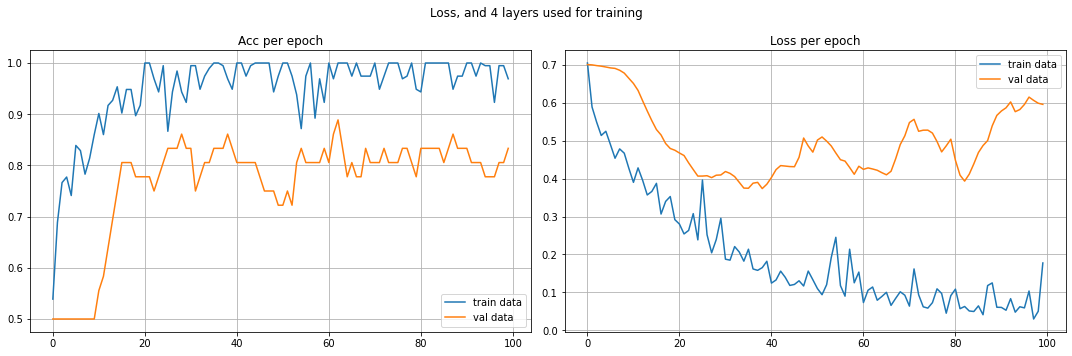

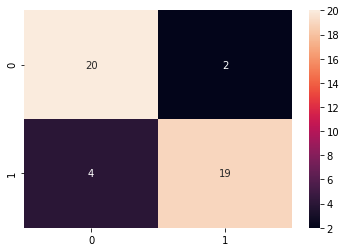

In [129]:
start_time = time.time()
test_model(Classifier_nn, sonar_df, sonar_df.shape[1] - 1, 4, [70, 35, 16, 8], F.relu, 2, 0.001, 100, 64)
end_time = time.time()
print('time took for the network to be trained :{}'.format(np.round(end_time - start_time, 3)))

### Auto Encoder dimensionality reduction

In [130]:
sonar_df = pd.read_csv('sonar.all-data', header=None)

In [131]:
sonar_y_df = sonar_df.pop(60)
sonar_y_df = pd.Series(pd.factorize(sonar_y_df)[0], name=60)
sonar_X_df = sonar_df

sonar_X_df, sonar_y_df = upsample_SMOTE(sonar_X_df, sonar_y_df)
sonar_df = pd.concat([sonar_X_df, sonar_y_df], axis=1)

222 222


In [132]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size, output_size):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU(), 
            nn.BatchNorm1d(output_size),
            nn.Linear(output_size, output_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(output_size, output_size),
            nn.ReLU(), 
            nn.BatchNorm1d(output_size),
            nn.Linear(output_size, input_size)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = F.relu(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x

In [133]:
train_df = sonar_df.sample(frac=1)

train_loader = to_dataloader(
    df=train_df, 
    target_col=60, 
    batch_size=64
)

auto_encoder_model = AutoEncoder(sonar_df.shape[1] - 1, 50)
auto_encoder_model.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(auto_encoder_model.parameters(), lr=0.001)

time took for autoencoder network to be trained :0.591


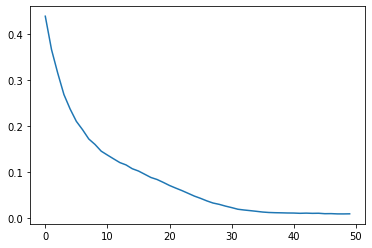

In [134]:
start_time = time.time()
epochs = 50
losses = []
for epoch in range(epochs):
    loss = 0
    for data, _ in train_loader:
        
        optimizer.zero_grad()
        
        outputs = auto_encoder_model(data)
        
        train_loss = criterion(outputs, data)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    
#     print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))
    losses.append(loss)
end_time = time.time()
print('time took for autoencoder network to be trained :{}'.format(np.round(end_time - start_time, 3)))
plt.plot(losses)

In [135]:
class Classifier_nn_with_autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, activation_function):
        super(Classifier_nn_with_autoencoder, self).__init__()
        self.activation_function = activation_function
        self.fcs = nn.ModuleList()
        self.bcs = nn.ModuleList()
        self.n_layers = n_layers
        self.fcs.append(nn.Linear(input_size, hidden_size[0]))
        self.bcs.append(nn.BatchNorm1d(hidden_size[0]))
        for i in range(self.n_layers - 1):
            self.fcs.append(nn.Linear(hidden_size[i], hidden_size[i + 1]))
            self.bcs.append(nn.BatchNorm1d(hidden_size[i + 1]))
        self.fcs.append(nn.Linear(hidden_size[-1], output_size))
    def forward(self, x):
        auto_encoder_model.eval()
        with torch.no_grad():
            x = auto_encoder_model.encode(x)
        auto_encoder_model.train()
        for i in range(self.n_layers):
            x = self.bcs[i](self.activation_function(self.fcs[i](x)))
        x = self.fcs[self.n_layers](x)
        x = x.squeeze(1)
        return x

  0%|          | 0/100 [00:00<?, ?it/s]

accuracy: 0.9111111164093018, loss: 0.2592366337776184
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91        22
         1.0       0.91      0.91      0.91        23

    accuracy                           0.91        45
   macro avg       0.91      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45

time took for the network to be trained :1.747


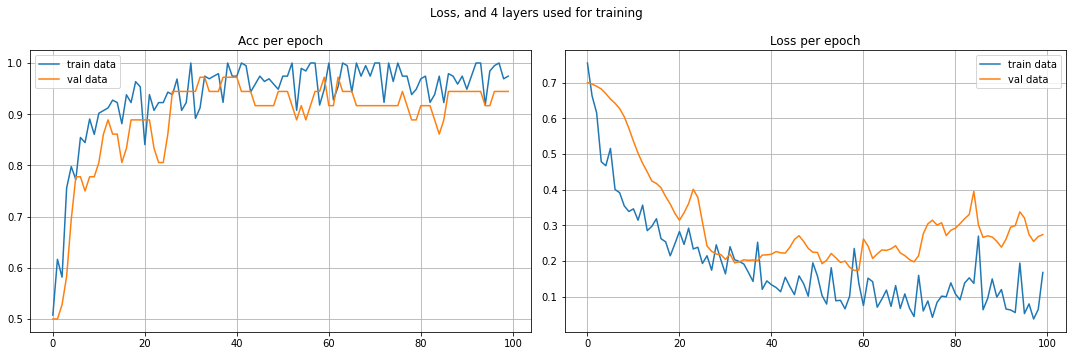

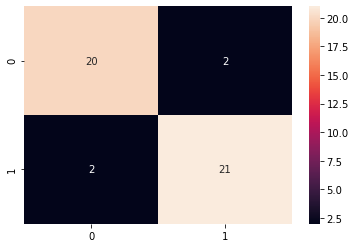

In [138]:
start_time = time.time()
test_model(Classifier_nn_with_autoencoder, sonar_df, 50, 4, [70, 35, 16, 8], F.relu, 2, 0.001, 100, 64)
end_time = time.time()
print('time took for the network to be trained :{}'.format(np.round(end_time - start_time, 3)))